<a href="https://colab.research.google.com/github/BCrnogorac/Belot/blob/main/Belot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In order for the project to work, we must install Tesseract OCR.

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
!sudo apt install libtesseract-dev
!pip install Pillow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libleptonica-dev
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,755 kB of archives.
After this operation, 13.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libleptonica-dev amd64 1.75.3-3 [1,308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract-dev amd64 4.00~git2288-10f4998a-2 [1,447 kB]
Fetched 2,755 kB in 1s (3,495 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/D

In [32]:
import numpy as np
import cv2
import pytesseract
import math
from google.colab.patches import cv2_imshow
from PIL import ImageEnhance, ImageFilter, Image

**crop_rect** function is used for cropping and rotating contours, which is how we're going to get single cards from an image

In [3]:
def crop_rect(rect, box, img):
    # get width and height of the detected rectangle
    width = int(rect[1][0])
    height = int(rect[1][1])

    src_pts = box.astype("float32")
    # coordinate of the points in box points after the rectangle has been
    # straightened
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped

**make_vertical** function is used for rotating images into vertical position

In [4]:
def make_vertical(img):
    if(img.shape[1] > img.shape[0]):
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img

**make_horizontal** function is used for rotating images into horizontal position

In [5]:
def make_horizontal(img):
    if(img.shape[0] > img.shape[1]):
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img

**count_white** function is for getting the ratio between black and white pixels, used for dissociating between *dames* and *kings*

In [6]:
def count_white(img):
    img = img.copy()
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    blur = cv2.GaussianBlur(grey,(25,25),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    count = np.count_nonzero(th3)
    length = np.size(th3)
    
    return count/length

**get_halves_difference** function is for calculating the difference between up and bottom halves of the sign image, used for dissociating between *acorns* and *bells*

In [7]:
def get_halves_difference(znak):
    # Finding the center of image
    y = int(znak[:,:,2].shape[0]/2)

    # Split the image
    top_half = znak[0:y,:,:]
    bot_half = znak[y:,:,:]
    
    # Calculate color means of images
    top_mean = abs(np.array(cv2.mean(top_half)).astype(np.int32))
    bot_mean = abs(np.array(cv2.mean(bot_half)).astype(np.int32))

    difference = abs(top_mean - bot_mean)
    # Biased towards difference in red channel
    split_dif = 2*difference[2] - difference[0] - difference[1]
    
    return split_dif

**rotate_image** function is used for rotating images

In [8]:
def rotate_image(image, angle):
      image_center = tuple(np.array(image.shape[1::-1]) / 2)
      rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
      result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
      return result

**check_number** function is for getting the actual number on the card from an output that is given through the OCR process

In [9]:
def check_number(text):
    text_new = ''
    for character in text:
        if(character == 'X' or character == 'x'):
            text_new += 'X'
        if(character == 'V' or character == 'v'):
            text_new += 'V'
        if (character == 'i' or character == 'l' or character == 'L' or character == 'I' or character == '1'):
            text_new += 'I'
    
    if (text_new == 'VII'):
        return 'SEDMICA'
    
    if(text_new == 'VIII'):
        return 'OSMICA'
    
    if(text_new == 'XI' or text_new == 'IX'):
        return 'DEVETKA'
    
    if(text_new == 'X'):
        return 'DESETKA'
    
    return False

**get_card_value function** is for assigning certain values to cards

In [10]:
def get_card_value(sign, result_shape):
    
    if(sign == 'DAMA'):
        return 3
    
    elif(sign == 'KRALJ'):
        return 4
    
    elif(sign == 'DECKO' and adut == result_shape):
        return 20
    
    elif(sign == 'DECKO'):
        return 2
        
    elif(sign == 'KEC'):
        return 11
     
    elif(sign == 'SEDMICA' or sign == 'OSMICA' or (sign == 'DEVETKA' and adut != result_shape)):
        return 0
     
    elif(sign == 'DEVETKA' and adut == result_shape):
        return 14
     
    elif(sign == 'DESETKA'):
        return 10
    return 0

**apply_ocr** function is for applying the Tesseract tools on a cropped image to read any text from it (or, in this case, numbers)

In [11]:
def apply_ocr(image):
    text = check_number(pytesseract.image_to_string(warped, config= config))
    if(text != False):
        return text
    text_90 = check_number(pytesseract.image_to_string(cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE), config= config))
    if(text_90 != False):
        return text_90
    text_180 = check_number(pytesseract.image_to_string(cv2.rotate(warped, cv2.ROTATE_180), config= config))
    if(text_180 != False):
        return text_180
    
    return 0

**get_max_split_difference** function is for getting max split difference through rotations of an image, also used for dissociating between *acorns* and *bells*

In [12]:
def get_max_split_difference(znak):
    # Rotate image in possible all ways
    differences = []
    up_dif = get_halves_difference(znak)
    differences.append(up_dif)
    up_dif = get_halves_difference(rotate_image(znak,45))
    differences.append(up_dif)
    up_dif = get_halves_difference(rotate_image(znak,-45))
    differences.append(up_dif)
    up_dif = get_halves_difference(cv2.rotate(znak, cv2.ROTATE_90_COUNTERCLOCKWISE))
    differences.append(up_dif)
    
    return max(differences)

**get_red_green_ratio** function is for getting the ratio between R and G channels of sign images, used for dissociating between *hearts* and *green*

In [13]:
def get_red_green_ratio(colors_values):
    b_channel = sum(row[0] for row in colors_values)
    g_channel = sum(row[1] for row in colors_values)
    r_channel = sum(row[2] for row in colors_values)
    
    red_ratio = r_channel / (b_channel + g_channel + r_channel)
    green_ratio = g_channel / (b_channel + g_channel + r_channel)
    
    red_green_ratio = red_ratio/green_ratio
    return red_green_ratio

**get_pictured_card** is function for distinguish between picture card (dame, king, ace, jack), based on distances between signs

In [14]:
def get_pictured_card(points, whitecount):
    points.sort(key=lambda x: x[1])
    distances = []
    for i in range(len(points)):
        for j in range(len(points)):
            if(i != j and points[j][0] and points[j][1]):
                distance = math.sqrt((points[i][1] - points[j][1])**2 + (points[i][0] - points[j][0])**2 )
                distances.append(distance)
    distances.sort(reverse= True)

    if(max(distances) < 220 and max(distances) > 140):
        return 'DECKO'
    elif(min(distances) < 220 and max(distances) > 320 and len(points) >= 3 and sum(distances)/len(distances) > 200):
        return 'KEC'
    elif(whitecount < 0.58 and max(distances) > 300):
        return 'KRALJ'
    elif(max(distances) > 300 and len(distances) <= 12):
        return 'DAMA'
    return 'UNKNOWN'

**get_card_color** function is used for dissociating between 4 signs (acorn, heart, bells, green) based on their red-green ratio (for hearts and green) and on their difference mean (bells and acorn)

In [15]:
def get_card_color(red_green_ratio, max_differences):
    # Difference mean between split images used for hazelnut or pumpkin
    difference_mean = sum(max_differences) / len(max_differences)
    
    result_znak = 'UNKNOWN'
    if(red_green_ratio > 1.6):
        result_znak = 'SRCE'
    if(red_green_ratio <= 1.04):
        result_znak = 'ZELENA'
    if(result_znak != 'SRCE' and result_znak != 'ZELENA'):
        if(difference_mean < 60):
            return 'BUNDEVA'
        if(difference_mean > 65):
            return'ZIR'
    return result_znak

Now we set up everything needed, such as loading the image (folder: 'slike/name.jpg'), setting up Tesseract and creating threshold and invert images that are needed for finding contours.

**Note**: Input should be in CAPS (SRCE, BUNDEVA, ZELENA or ZIR)

Unesite adut: 
SRCE
Unjeli ste adut:  SRCE


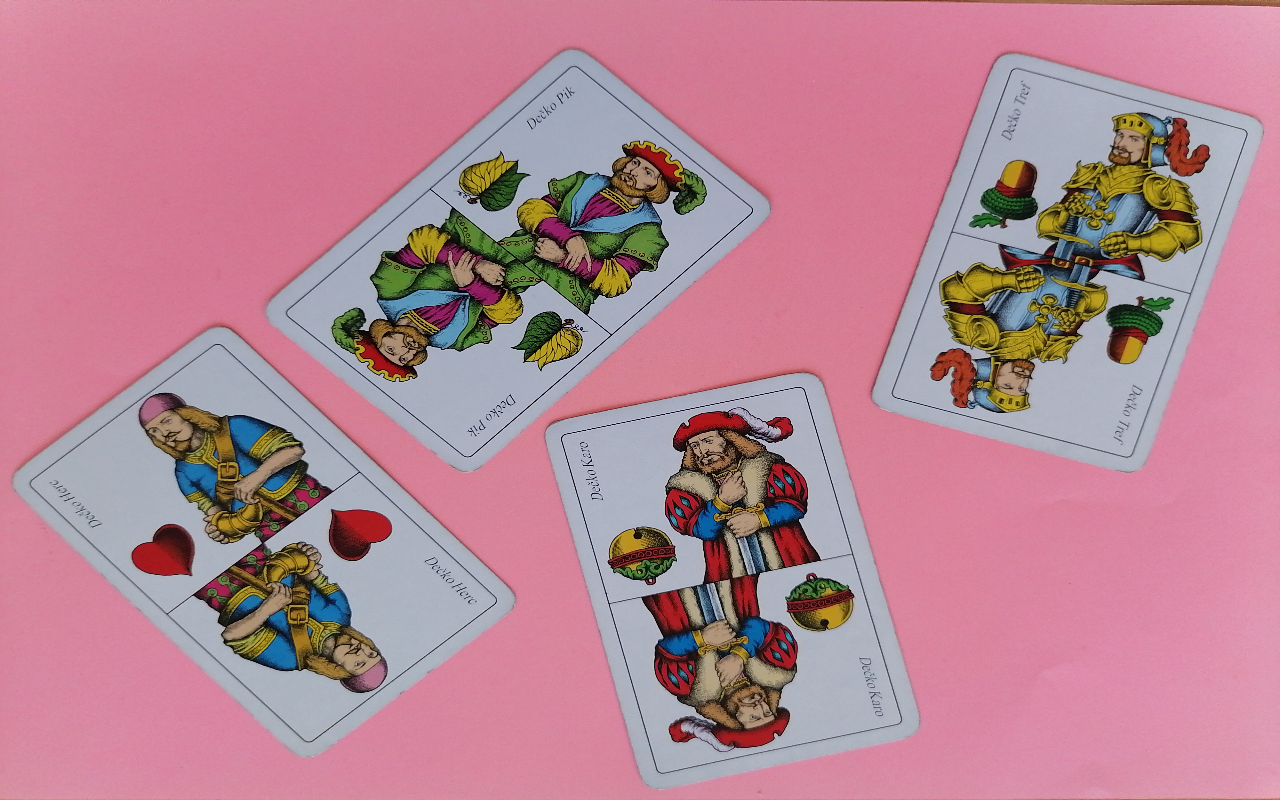

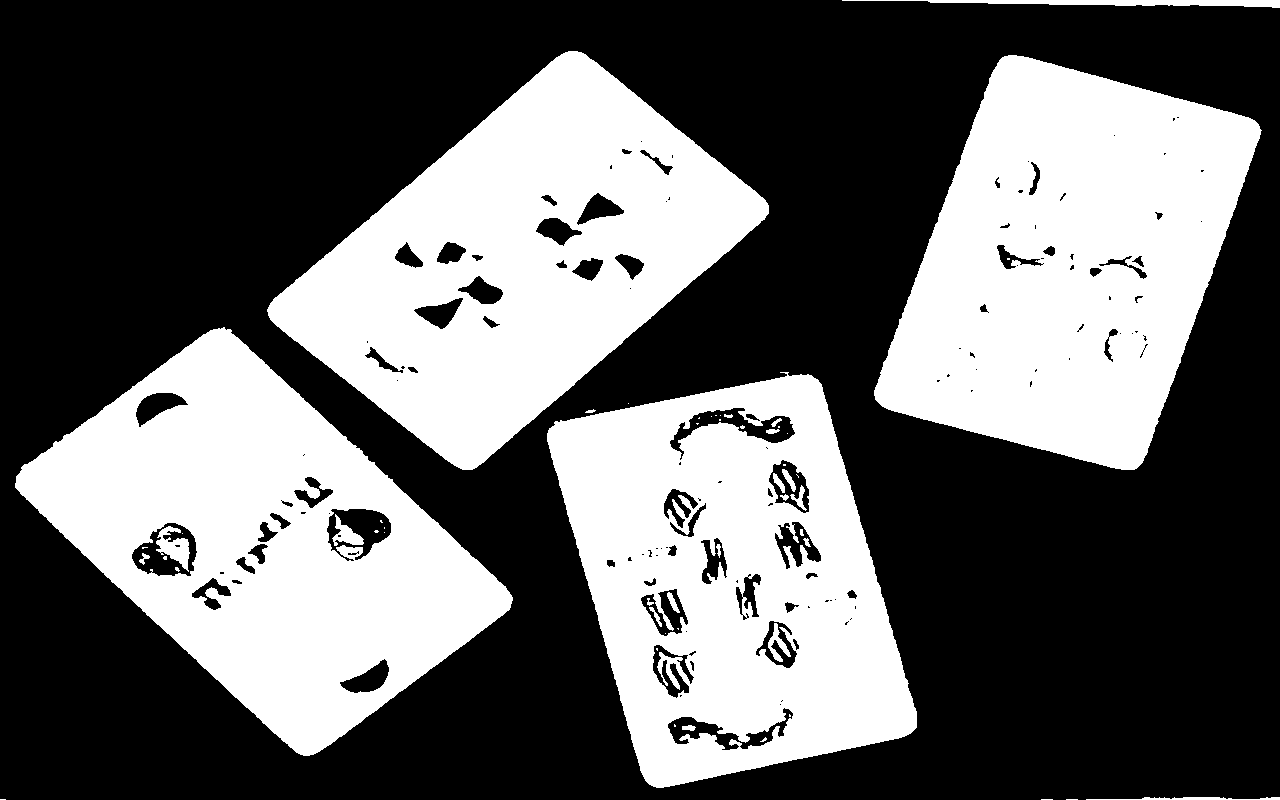

In [43]:
print('Unesite adut: ')
adut = input()
print('Unjeli ste adut: ', adut)

im = cv2.imread('slike/decki1.jpg',1)
img = cv2.resize(im, (1280, 800))    
cv2_imshow(img)

config = ('-l eng --oem 1 --psm 6')
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

blur = cv2.GaussianBlur(hsv,(5,5),0)
ret, thresh_H = cv2.threshold(blur[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

invert_H = cv2.bitwise_not(thresh_H)
cv2_imshow(invert_H)


Further, we find contours based on the inverted image, cut the cards into separate images and rotate them to be vertical

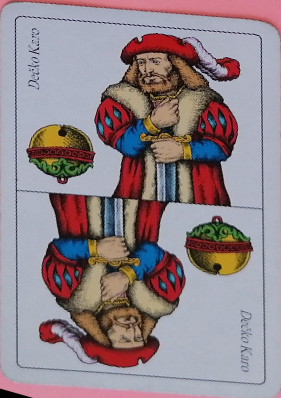

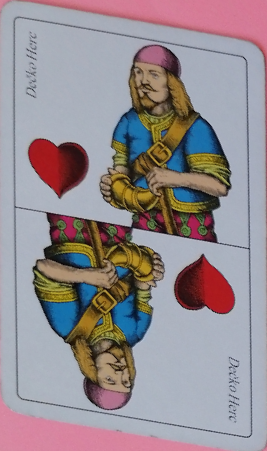

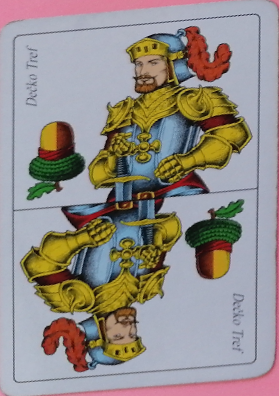

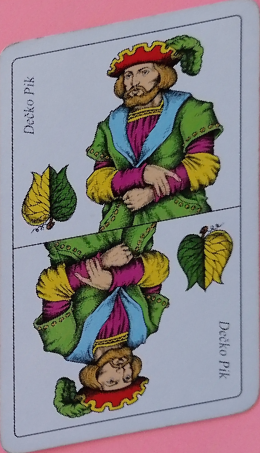

In [44]:
contours,hierarchy = cv2.findContours(invert_H.astype(np.uint8), cv2.RETR_EXTERNAL, 2)
cards = []

cnts = contours
for cnt in cnts:
    area = cv2.contourArea(cnt)
    if ((area > 10000)): # filter small contours
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        warped = make_vertical(crop_rect(rect,box,img))
        cards.append(warped)


for card in cards:
    cv2_imshow(card)


Karta je  DECKO
Boja je  BUNDEVA


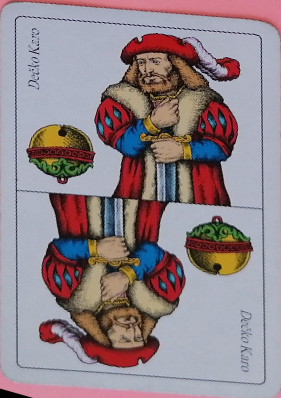

Karta je  DECKO
Boja je  SRCE


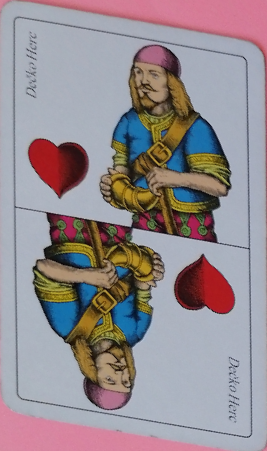

Karta je  DECKO
Boja je  ZIR


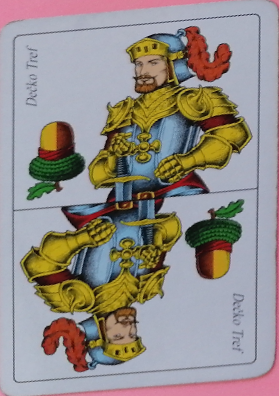

Karta je  DECKO
Boja je  ZELENA


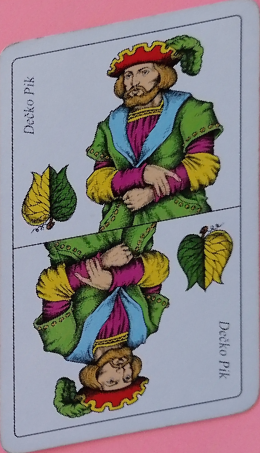

Suma je:  26


In [45]:
suma = 0
for i in range(4):
    # GETTING PICTURE AND SHAPE OF CARD ------------------------------------------------------
    img = cards[i].copy()
    # Whitecount needed to differ kings from dames
    # Implying the card isnt a number
    whitecount = count_white(img)
    
    # Transform channels and threshold the image
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    ret, thresh_S = cv2.threshold(hsv[:,:,1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(thresh_S, (3,3),0)
    ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Erode and dilate to get rid of details
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    erodion = cv2.erode(thresh, rect_kernel, iterations = 5)
    dilate = cv2.dilate(erodion, rect_kernel, iterations = 3)
    
    # Setup
    contours, hierarchy = cv2.findContours(dilate.astype(np.uint8), 1, 2)
    max_differences = []
    colors_values = []
    points = []
    result_rank = 'UNKNOWN'
    result_number = 0

    for cnt in contours:
        area = cv2.contourArea(cnt)
        differences = []
        if (area > 1500 and area < 10000): # filter small contours
            x,y,w,h = cv2.boundingRect(cnt) # offsets - with this you get 'mask'
            znak = img[y:y+h,x:x+w]
            
            
            # Cropping the center of the contour for 
            # more precision when analyzing RGB channels
            x_c = int(znak.shape[0] / 2)
            y_c = int(znak.shape[1] / 2)
            h_c = int(y_c / 1.5)
            w_c = int(x_c / 1.5)
            center = znak[x_c - w_c : x_c + w_c, y_c - h_c : y_c + h_c]

            # In case of a pictured card, shapes will be single
            # or
            # In case of a numbered card, shapes will be stacked
            if( (znak.shape[0] >= 37 and znak.shape[0] < 75 and znak.shape[1] >= 37 and znak.shape[1]<75) or
               (znak.shape[0] > 75  and znak.shape[0] < 200 and znak.shape[1] < 75 and znak.shape[0] > (znak.shape[1] + znak.shape[0] / 3))):
                # Save color values to calculate the color of the shape
                colors_bgr = np.array(cv2.mean(center)).astype(np.uint8)
                colors_values.append(colors_bgr)
                
                # Save the maximum difference between
                # top and bottom part of a shape
                card_split_difference = get_max_split_difference(znak)
                max_differences.append(card_split_difference)
                if(znak.shape[0] <= 75 and znak.shape[1] <= 75):
                    # Save x and y coordinates for
                    # Calculating distance between shapes
                    points.append([y,x])
                
                
                     
    
    # Get the pictured card
    if(len(points) > 1):
        result_rank = get_pictured_card(points, whitecount)
    
    #GETTING THE TYPE OF CARD (NUMBER)-------------------------------------------------------------
    img = cards[i].copy()

    # Everything that isn't black turns to white
    imtext = img.copy()
    imtext[imtext[:,:,0] > 25] = 255
    imtext[imtext[:,:,1] > 25] = 255
    imtext[imtext[:,:,2] > 25] = 255
    
    graytext = cv2.cvtColor(imtext, cv2.COLOR_BGR2GRAY)
    
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(graytext,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Another thresholding
    blurtext = cv2.GaussianBlur(th3,(5,5),0)
    ret, thresh1 = cv2.threshold(blurtext, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    # Erode image to try and reduce everything that isn't numbers to nothing
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    erodion = cv2.erode(thresh1, rect_kernel, iterations = 4)
    
    # Enlarge everything that passed erodion to get the contours in which are numbers
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
    dilationtext = cv2.dilate(erodion, rect_kernel, iterations = 6)
    
    # Finding contours
    contours, hierarchy = cv2.findContours(dilationtext, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
     
    # Looping through the identified contours
    # Then rectangular part is cropped and passed on
    # to pytesseract for extracting text from it
    # Extracted text is then written into the text file
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if ((area > 700) and area < 4000): # filter contours outside of scope of numbers
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            # Rotate contour of numbers
            warped = make_horizontal(crop_rect(rect,box,img))

            # Apply OCR on the numbers image
            read_value = apply_ocr(warped)
            if(read_value != 0):
                result_number = read_value
            
    result_value = result_rank
    if(result_number != 0):
        result_value = result_number
    if(result_rank != 'UNKNOWN' and result_number == 'DESETKA'):
        result_value = result_rank
    if(result_number != 0 and result_rank == 'DECKO'):
        result_value = result_number

    # Getting the color of the card used for red or green
    red_green_ratio = get_red_green_ratio(colors_values)
    result_shape = get_card_color(red_green_ratio, max_differences)
    
    print('Karta je ', result_value)
    print('Boja je ', result_shape)
    
    suma = suma + get_card_value(result_value, result_shape)

    cv2_imshow(img)



And finally, getting the total sum of the original card

In [46]:
print('Suma je: ', suma)

Suma je:  26
